In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Wallpoet&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Wallpoet; color:#33ffcc;'>
    %s</h1>"""%str))

Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/gnn/gnn-basic-graph-spectral-1.ipynb)

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torch.utils.data.dataset import Subset
import tensorflow.image as timage
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import eigsh
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [5]:
@register_line_magic
def display_examples(n):
    if n=='1': data_loader=train_loader1
    if n=='2': data_loader=train_loader2
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size),
                      cmap=pl.cm.bone)
        break

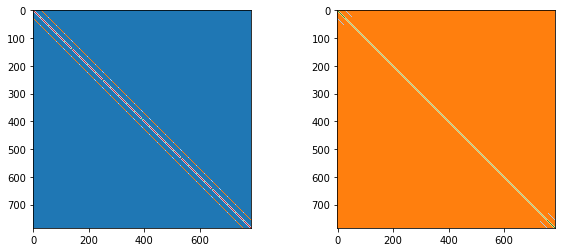

In [6]:
def calc_adjacency_matrix(img_size):
    col,row=np.meshgrid(np.arange(img_size),
                        np.arange(img_size))
    coord=np.stack((col,row),axis=2)\
    .reshape(-1,2)/img_size
    dist=cdist(coord,coord,metric='euclidean')
    sigma=.05*np.pi
    A=np.exp(-dist/sigma**2)
    A[A<.01]=0
    return torch.from_numpy(A).float()
def laplacian_graph(A):
    N=A.shape[0]; D=np.sum(A,0)
    D_hat=np.diag((D+1e-5)**(-.5))
    L=np.identity(N)-np.dot(D_hat,A).dot(D_hat)
    return torch.from_numpy(L).float()
A=calc_adjacency_matrix(28)
fig=pl.figure(figsize=(10,4))
ax=fig.add_subplot(1,2,1)
ax.imshow(A,cmap='tab20')
ax=fig.add_subplot(1,2,2)
ax.imshow(laplacian_graph(A.numpy()),cmap='tab20');

In [7]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader1,valid_loader1,test_loader1]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

In [8]:
@register_line_magic
def fit_plot(pars):
    if pars=='loss':
        pl.plot(lcost,label='Minibatch Cost')
        pl.plot(np.convolve(lcost,np.ones(200,)/200,
                            mode='valid'), 
                label='Running Average')
        pl.ylabel('Cross Entropy')
        pl.xlabel('Iterations')
    if pars=='acc':
        pl.plot(lacc_train,label='Train Acc')
        pl.plot(lacc_valid,label='Valid Acc')        
        pl.ylabel('Accuracy')
        pl.xlabel('Epochs')
    pl.grid(); pl.legend()

In [9]:
dhtml('Data')

In [10]:
img_size=28
random_seed=12; batch_size1=256
train_ids=torch.arange(0,57000)
valid_ids=torch.arange(57000,60000)
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor()])
train_valid=tmnist(root='data',train=True,
                   download=True,
                   transform=trans)
train1=Subset(train_valid,train_ids)
valid1=Subset(train_valid,valid_ids)
test1=tmnist(root='data',train=False, 
             transform=trans)
train_loader1=tdl(dataset=train1,shuffle=True, 
                  batch_size=batch_size1)
valid_loader1=tdl(dataset=valid1,shuffle=True, 
                  batch_size=batch_size1)
test_loader1=tdl(dataset=test1,shuffle=False, 
                 batch_size=batch_size1)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.





Image dimensions: torch.Size([256, 1, 28, 28])
Label dimensions: torch.Size([256])



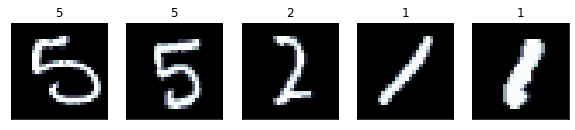

In [11]:
%display_examples 1

In [12]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=1-np.array(f[keys[1]],dtype='float32')/255
x=timage.resize(x,[img_size,img_size])
x=(np.dot(x.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
random_seed=23; batch_size2=64
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
valid_loader2=tdl(dataset=valid2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

['backgrounds', 'images', 'labels']


Image dimensions: torch.Size([64, 1, 28, 28])
Label dimensions: torch.Size([64])


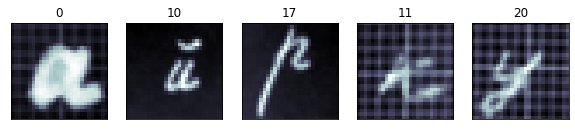

In [13]:
%display_examples 2

In [14]:
dhtml('Basic Graph Neural Networks <br/>with Spectral Graph Convolution')

In [15]:
class GraphNN(tnn.Module):
    def __init__(self,img_size,num_filters,num_classes):
        super(GraphNN,self).__init__()
        num_rows=img_size**2
        self.fc=tnn.Linear(num_rows*num_filters,
                           num_classes,bias=False)
        A=calc_adjacency_matrix(img_size)
        L=laplacian_graph(A.numpy())
        Λ,V=eigsh(L.numpy(),k=20,which='SM')
        V=torch.from_numpy(V)
        W_spectral=tnn.Parameter(torch\
        .ones((num_rows,num_filters))).float()
        tnn.init.kaiming_uniform_(W_spectral)      
        self.register_buffer('A',A)
        self.register_buffer('L',L)
        self.register_buffer('V',V)
        self.register_buffer('W_spectral',W_spectral)
    def forward(self,x): 
        B=x.size(0)
        V_tensor=self.V.unsqueeze(0)
        V_tensor=self.V.expand(B,-1,-1)
        V_tensor_T=self.V.T.unsqueeze(0)
        V_tensor_T=self.V.T.expand(B,-1,-1)
        x_reshape=x.view(B,-1,1)
        W_spectral_tensor=self.W_spectral.unsqueeze(0)
        W_spectral_tensor=self.W_spectral.expand(B,-1,-1)
        X_hat=V_tensor_T.bmm(x_reshape)
        W_hat=V_tensor_T.bmm(W_spectral_tensor)
        Y=V_tensor.bmm(X_hat *W_hat)
        logits=self.fc(Y.reshape(B,-1))
        probs=tnnf.softmax(logits,dim=1)
        return logits,probs

In [16]:
dhtml('Training')

In [17]:
@register_line_magic
def train_run(pars):
    [n,epochs]=[int(el) for el in pars.split()]
    if n==1:
        train_loader=train_loader1
        valid_loader=valid_loader1
        train=train1; batch_size=batch_size1
    if n==2:
        train_loader=train_loader2
        valid_loader=valid_loader2
        train=train2; batch_size=batch_size2
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad()
            cost.backward(); lcost.append(cost.item())
            optimizer.step()
            if not batch_ids%100:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()
        with torch.set_grad_enabled(False):
            train_acc=model_acc(model,train_loader)
            valid_acc=model_acc(model,valid_loader)
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,train_acc,valid_acc))
            lacc_train.append(train_acc)
            lacc_valid.append(valid_acc)

In [18]:
torch.manual_seed(random_seed)
num_classes=10; num_filters=3
learning_rate=.05
lcost,lacc_train,lacc_valid=[],[],[]
model=GraphNN(img_size=img_size,
              num_filters=num_filters,
              num_classes=num_classes)
model=model.to(dev)
optimizer=torch.optim.SGD(model.parameters(),
                          lr=learning_rate) 

In [19]:
%train_run 1 70

Epoch: 001/070 | Batch 000/222 | Cost: 2.3133
Epoch: 001/070 | Batch 100/222 | Cost: 1.3793
Epoch: 001/070 | Batch 200/222 | Cost: 1.2523
Epoch: 001/070 train acc: 71.94% valid acc: 75.87%
Epoch: 002/070 | Batch 000/222 | Cost: 1.1590
Epoch: 002/070 | Batch 100/222 | Cost: 1.0923
Epoch: 002/070 | Batch 200/222 | Cost: 0.9927
Epoch: 002/070 train acc: 74.53% valid acc: 78.63%
Epoch: 003/070 | Batch 000/222 | Cost: 0.9268
Epoch: 003/070 | Batch 100/222 | Cost: 0.9026
Epoch: 003/070 | Batch 200/222 | Cost: 0.9133
Epoch: 003/070 train acc: 75.91% valid acc: 80.20%
Epoch: 004/070 | Batch 000/222 | Cost: 0.9164
Epoch: 004/070 | Batch 100/222 | Cost: 0.9504
Epoch: 004/070 | Batch 200/222 | Cost: 0.8264
Epoch: 004/070 train acc: 76.48% valid acc: 81.07%
Epoch: 005/070 | Batch 000/222 | Cost: 0.7718
Epoch: 005/070 | Batch 100/222 | Cost: 0.7802
Epoch: 005/070 | Batch 200/222 | Cost: 0.7950
Epoch: 005/070 train acc: 77.16% valid acc: 80.97%
Epoch: 006/070 | Batch 000/222 | Cost: 0.8109
Epoch: 00

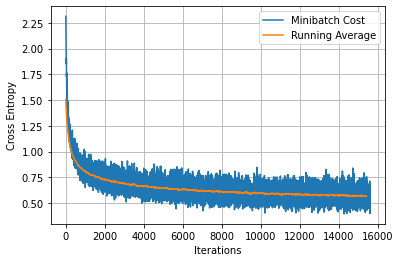

In [20]:
%fit_plot loss

Train accuracy: 83.2597%
Valid accuracy: 87.2333%
Test accuracy: 84.5600%


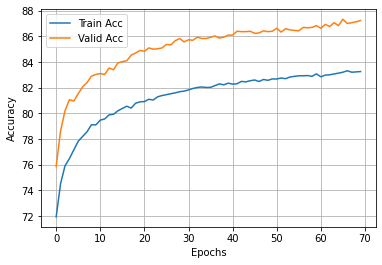

In [21]:
%print_acc 1
%fit_plot acc

In [26]:
torch.manual_seed(random_seed)
num_classes=33; num_filters=14
learning_rate=.05
lcost,lacc_train,lacc_valid=[],[],[]
model=GraphNN(img_size=img_size,
              num_filters=num_filters,
              num_classes=num_classes)
model=model.to(dev)
optimizer=torch.optim.SGD(model.parameters(),
                          lr=learning_rate) 

In [27]:
%train_run 2 300

Epoch: 001/300 | Batch 000/177 | Cost: 3.4902
Epoch: 001/300 | Batch 100/177 | Cost: 3.4730
Epoch: 001/300 train acc: 3.89% valid acc: 4.23%
Epoch: 002/300 | Batch 000/177 | Cost: 3.6134
Epoch: 002/300 | Batch 100/177 | Cost: 3.4901
Epoch: 002/300 train acc: 5.00% valid acc: 5.14%
Epoch: 003/300 | Batch 000/177 | Cost: 3.4901
Epoch: 003/300 | Batch 100/177 | Cost: 3.4264
Epoch: 003/300 train acc: 4.70% valid acc: 4.44%
Epoch: 004/300 | Batch 000/177 | Cost: 3.3862
Epoch: 004/300 | Batch 100/177 | Cost: 3.4641
Epoch: 004/300 train acc: 5.99% valid acc: 5.36%
Epoch: 005/300 | Batch 000/177 | Cost: 3.4170
Epoch: 005/300 | Batch 100/177 | Cost: 3.4252
Epoch: 005/300 train acc: 6.54% valid acc: 6.34%
Epoch: 006/300 | Batch 000/177 | Cost: 3.3892
Epoch: 006/300 | Batch 100/177 | Cost: 3.3559
Epoch: 006/300 train acc: 7.51% valid acc: 5.99%
Epoch: 007/300 | Batch 000/177 | Cost: 3.3045
Epoch: 007/300 | Batch 100/177 | Cost: 3.3041
Epoch: 007/300 train acc: 9.77% valid acc: 8.95%
Epoch: 008/30

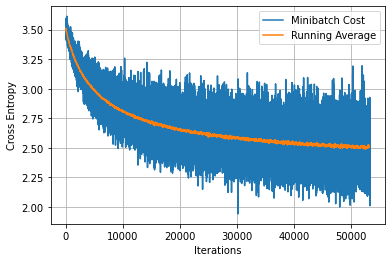

In [28]:
%fit_plot loss

Train accuracy: 30.7435%
Valid accuracy: 28.6117%
Test accuracy: 30.5849%


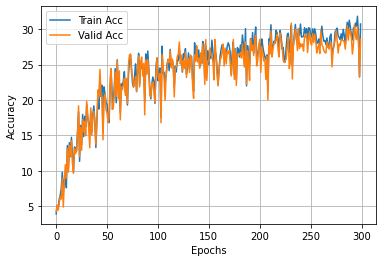

In [29]:
%print_acc 2
%fit_plot acc